# Implementation: Medium Design a Movie Recommendation System with using Graph Database (neo4j) — part 1

- link:https://medium.com/@yesilliali/design-a-movie-recommendation-system-with-using-graph-database-neo4j-part-1-2c4933f4da0a

## preview data 

In [1]:
import os 
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
os.listdir('./data')

['links.csv',
 'tags.csv',
 'genome-tags.csv',
 'ratings.csv',
 'README.txt',
 'genome-scores.csv',
 'movies.csv']

In [9]:
tag_df = pd.read_csv('./data/genome-scores.csv') 
movie_df = pd.read_csv('./data/movies.csv') 
rating_df = pd.read_csv('./data/ratings.csv')

In [10]:
tag_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [11]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
rating_df.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [13]:
# how many users and movies?
print('user unique:',rating_df['userId'].nunique())
print('movie unique:',rating_df['movieId'].nunique())

user unique: 162541
movie unique: 59047


In [14]:
'''
依照原本的方法，在計算 cos similarity 的時候，會需要耗用大量的 RAM
因為他是一個稀疏矩陣，當有 N 個電影，就會創立 N*N 大小的矩陣
那這次實驗先縮小 movie 數量嘗試看看
'''

# limit to 1000 movies
movieId_list = movie_df['movieId'].sample(1000)

tag_df = tag_df[tag_df['movieId'].isin(movieId_list)]
movie_df = movie_df[movie_df['movieId'].isin(movieId_list)]
rating_df = rating_df[rating_df['movieId'].isin(movieId_list)]

print(tag_df.shape
      ,movie_df.shape
      ,rating_df.shape)

(274104, 3) (1000, 3) (354197, 4)


In [15]:
tag_df.groupby('movieId')['tagId'].nunique().reset_index()


,movieId,tagId
0,32,1128
1,122,1128
2,152,1128
3,157,1128
4,188,1128
...,...,...
238,183843,1128
239,185001,1128
240,189819,1128
241,196417,1128


In [18]:
tag_df[tag_df['movieId'] == 28]

,movieId,tagId,relevance


In [19]:
tag_df[tag_df['movieId'] == 220]

,movieId,tagId,relevance


## preprocess for movie matrix

### genome_scores

-  For each `movieId`, there is a corresponding `relevance` value for each `tagId`, with a total of 1,128 `tagId`s.
- The current format shows one `movieId` and one `tagId` per row. We need to transform it so each row represents one `movieId` with relevance values for all 1,128 `tagId`s.

In [20]:
tag_df.groupby('movieId')['tagId'].nunique().reset_index()

,movieId,tagId
0,32,1128
1,122,1128
2,152,1128
3,157,1128
4,188,1128
...,...,...
238,183843,1128
239,185001,1128
240,189819,1128
241,196417,1128


In [21]:
tag_df

,movieId,tagId,relevance
34968,32,1,0.02400
34969,32,2,0.02200
34970,32,3,0.09150
34971,32,4,0.10875
34972,32,5,0.10900
...,...,...,...
15544963,201588,1124,0.08775
15544964,201588,1125,0.05525
15544965,201588,1126,0.03200
15544966,201588,1127,0.12600


In [22]:
tag_df = tag_df.pivot(index=['movieId'], columns=['tagId'], values='relevance').reset_index()
tag_df.head(3)
# scores_pivot = genome_scores_data.pivot_table(index = ["movieId"],columns = ["tagId"],values = "relevance").reset_index()


tagId,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,32,0.02400,0.0220,0.09150,0.10875,0.10900,0.1420,0.07725,0.14250,0.08000,...,0.13175,0.03400,0.01725,0.05200,0.2655,0.1325,0.02700,0.01450,0.08725,0.02725
1,122,0.07300,0.0825,0.02825,0.04625,0.06375,0.0510,0.04875,0.10775,0.11925,...,0.09125,0.01800,0.00950,0.03700,0.2340,0.0690,0.02325,0.00950,0.08350,0.01625
2,152,0.02325,0.0255,0.03200,0.03875,0.04200,0.0255,0.02825,0.11025,0.07925,...,0.05500,0.01425,0.01025,0.06125,0.2865,0.0565,0.03650,0.00625,0.31900,0.04375


### movies_data 

- process genres col, transfrom it to each row represents a single `movieId`, and the columns represent the `genres`. 

In [23]:
caculate_genres_df = movie_df['genres'].str.get_dummies(sep='|')
caculate_genres_df.insert(0, 'movieId', movie_df['movieId'])
caculate_genres_df.drop(columns=['(no genres listed)'])
caculate_genres_df.head()


,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
31,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
120,122,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
150,152,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
155,157,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
186,188,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### ratings_data

- first, extract the year from `title`, but note that some titles do not include parentheses and a year.

In [24]:
print(rating_df.head(1))
print(movie_df.head(1))

    userId  movieId  rating   timestamp
59       1     8405     3.5  1147878095
    movieId                                      title  \
31       32  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                     genres  
31  Mystery|Sci-Fi|Thriller  


In [25]:
title_list = movie_df['title'].tolist()

for i in title_list:
    if not '(' in i:
        print(i)

The Lost City of Cecil B. DeMille


In [26]:
def get_title_year(x):
    if '(' in x and ')' in x:
        if (x.split('(')[1])[0:4].isdigit():
            return (x.split('(')[1])[0:4]
        else:
            return np.nan
    else:
        return np.nan

caculate_movie_year_df = movie_df.copy()
caculate_movie_year_df['title_year'] = movie_df['title'].apply(lambda x: get_title_year(x) )


In [27]:
caculate_movie_year_df

,movieId,title,genres,title_year
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,NaN
120,122,Boomerang (1992),Comedy|Romance,1992
150,152,"Addiction, The (1995)",Drama|Horror,1995
155,157,Canadian Bacon (1995),Comedy|War,1995
186,188,"Prophecy, The (1995)",Fantasy|Horror|Mystery,1995
...,...,...,...,...
61971,207419,So You Think You're Not Guilty (1950),Comedy,1950
61990,207469,Sweetheart (2019),Horror,2019
62150,208082,Dark Encounter (2019),Horror|Sci-Fi,2019
62185,208199,Rufus (2013),Drama,2013


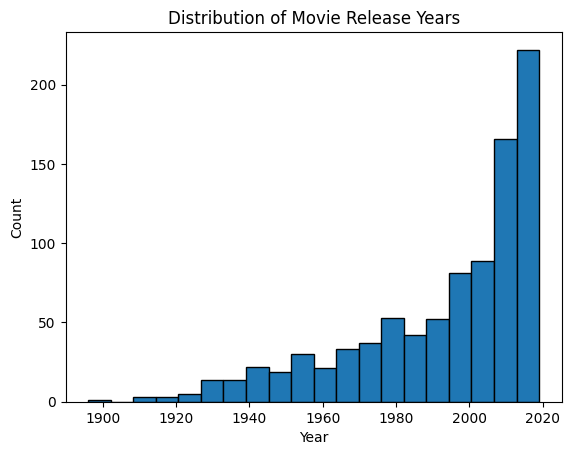

In [28]:
caculate_movie_year_df['title_year'] = pd.to_numeric(caculate_movie_year_df['title_year'], errors='coerce')

caculate_movie_year_df['title_year'].dropna().plot(
    kind='hist',
    bins=20,   
    edgecolor='black',
    title='Distribution of Movie Release Years'
)

plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [29]:
print(caculate_movie_year_df['title_year'].min())
print(caculate_movie_year_df['title_year'].max())
print(caculate_movie_year_df['title_year'].median())



1896.0
2019.0
2002.0


In [30]:
num_bins = 5 
bins = np.linspace(caculate_movie_year_df['title_year'].min(), caculate_movie_year_df['title_year'].max(), num_bins + 1)
caculate_movie_year_df['year_group'] = pd.cut(caculate_movie_year_df['title_year'], bins=bins, labels=range(1, num_bins + 1))
caculate_movie_year_df['year_group'] = caculate_movie_year_df['year_group'].cat.add_categories([0]).fillna(0)
caculate_movie_year_df.head(10)

,movieId,title,genres,title_year,year_group
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,NaN,0
120,122,Boomerang (1992),Comedy|Romance,1992.0,4
150,152,"Addiction, The (1995)",Drama|Horror,1995.0,5
155,157,Canadian Bacon (1995),Comedy|War,1995.0,5
186,188,"Prophecy, The (1995)",Fantasy|Horror|Mystery,1995.0,5
256,259,Kiss of Death (1995),Crime|Drama|Thriller,1995.0,5
287,290,Once Were Warriors (1994),Crime|Drama,1994.0,4
308,312,Stuart Saves His Family (1995),Comedy,1995.0,5
369,374,Richie Rich (1994),Children|Comedy,1994.0,4
387,392,"Secret Adventures of Tom Thumb, The (1993)",Adventure|Animation,1993.0,4


In [31]:
caculate_movie_year_df[caculate_movie_year_df['title_year'].isna()]

,movieId,title,genres,title_year,year_group
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,NaN,0
563,570,"Slingshot, The (Kådisbellan) (1993)",Comedy|Drama,NaN,0
781,797,"Old Lady Who Walked in the Sea, The (Vieille q...",Comedy,NaN,0
807,825,Regular Guys (Echte Kerle) (1996),Comedy|Romance,NaN,0
1089,1117,"Eighth Day, The (Huitième jour, Le) (1996)",Drama,NaN,0
...,...,...,...,...,...
24170,120829,Scattered Clouds (Midaregumo) (1967),Drama,NaN,0
31294,138224,East Wind (Vent d'Est) (1993),Drama,NaN,0
34557,145733,(The New) War of the Buttons (2011),Adventure|Children,NaN,0
46138,171833,Surviving Life (Theory and Practice) (2010),Animation|Comedy|Fantasy,NaN,0


In [32]:
caculate_movie_year_df = caculate_movie_year_df[['movieId','year_group']]
caculate_movie_year_df.head()

,movieId,year_group
31,32,0
120,122,4
150,152,5
155,157,5
186,188,5


In [33]:
caculate_rating_count_df = rating_df.groupby('movieId')['timestamp'].count().reset_index(name='rating_count')


In [34]:
caculate_rating_count_df['rating_count'].describe()

count      941.000000
mean       376.404888
std       2475.372519
min          1.000000
25%          2.000000
50%          7.000000
75%         47.000000
max      47054.000000
Name: rating_count, dtype: float64

In [35]:
def rating_count_group(x):
    if x<2:
        # 極少評價的電影
        return 0
    elif x<=6:
        # 少量評價
        return 1
    elif x<=33:
        # 中等評價
        return 2
    else:
        # 大量評價
        return 3 

caculate_rating_count_df['rating_count_group'] = caculate_rating_count_df['rating_count'].apply(lambda x:rating_count_group(x))
caculate_rating_count_df.head(3)

,movieId,rating_count,rating_count_group
0,32,47054,3
1,122,3588,3
2,152,638,3


In [36]:
caculate_rating_mean_df =rating_df.groupby('movieId')['rating'].mean().reset_index(name='rating_mean')
caculate_rating_mean_df.describe()

,movieId,rating_mean
count,941.000000,941.000000
mean,114926.641870,3.050607
std,66741.851562,0.711043
min,32.000000,0.500000
25%,62781.000000,2.677835
50%,129986.000000,3.107143
75%,171833.000000,3.500000
max,208219.000000,5.000000


In [37]:
def rating_mean_group(x):
    if x<=2:
        # 評分低
        return 0
    elif x<=3:
        # 普通評分
        return 1
    elif x<=4:
        # 高評分
        return 2
    else:
        # 非常高
        return 3 
    
caculate_rating_mean_df['rating_mean_group'] = caculate_rating_mean_df['rating_mean'].apply(lambda x:rating_mean_group(x))
caculate_rating_mean_df.head(3)

,movieId,rating_mean,rating_mean_group
0,32,3.905768,2
1,122,2.859392,1
2,152,3.086991,2


In [38]:
caculate_movie_year_df

,movieId,year_group
31,32,0
120,122,4
150,152,5
155,157,5
186,188,5
...,...,...
61971,207419,3
61990,207469,5
62150,208082,5
62185,208199,5


In [39]:

caculate_rating_group_df = caculate_movie_year_df.merge(caculate_rating_count_df, on='movieId', how='left')
caculate_rating_group_df = caculate_rating_group_df.merge(caculate_rating_mean_df, on='movieId', how='left')
caculate_rating_group_df = caculate_rating_group_df[['movieId', 'year_group', 'rating_count_group', 'rating_mean_group']]
caculate_rating_group_df['rating_count_group'] = caculate_rating_group_df['rating_count_group'].fillna(-1)
caculate_rating_group_df['rating_mean_group'] = caculate_rating_group_df['rating_mean_group'].fillna(-1)

caculate_rating_group_df.head(3)

,movieId,year_group,rating_count_group,rating_mean_group
0,32,0,3.0,2.0
1,122,4,3.0,1.0
2,152,5,3.0,2.0



## using prprocess data to caculate similarity 

1. tag_df: using tag to caculate cos similarity (13816 movies)
2. 

In [40]:
tag_df.head(3)

tagId,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,32,0.02400,0.0220,0.09150,0.10875,0.10900,0.1420,0.07725,0.14250,0.08000,...,0.13175,0.03400,0.01725,0.05200,0.2655,0.1325,0.02700,0.01450,0.08725,0.02725
1,122,0.07300,0.0825,0.02825,0.04625,0.06375,0.0510,0.04875,0.10775,0.11925,...,0.09125,0.01800,0.00950,0.03700,0.2340,0.0690,0.02325,0.00950,0.08350,0.01625
2,152,0.02325,0.0255,0.03200,0.03875,0.04200,0.0255,0.02825,0.11025,0.07925,...,0.05500,0.01425,0.01025,0.06125,0.2865,0.0565,0.03650,0.00625,0.31900,0.04375


In [ ]:
tag_df = tag_df.set_index('movieId')
cos_tag = cosine_similarity(tag_df.values)

print(tag_df.shape)
print(cos_tag.shape)



KeyError: "None of ['movieId'] are in the columns"

In [42]:

caculate_genres_df = caculate_genres_df.set_index('movieId')
cos_genres = cosine_similarity(caculate_genres_df.values)

print(caculate_genres_df.shape)
print(cos_genres.shape)


(1000, 20)
(1000, 1000)


In [43]:
caculate_rating_group_df = caculate_rating_group_df.set_index('movieId')
cos_rating = cosine_similarity(caculate_rating_group_df.values)

print(caculate_rating_group_df.shape)
print(cos_rating.shape)


(1000, 3)
(1000, 1000)


In [47]:
max_shape = max(cos_tag.shape[0], cos_genres.shape[0], cos_rating.shape[0])

def pad_matrix(matrix, target_shape):
    padded_matrix = np.zeros((target_shape, target_shape))
    padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    return padded_matrix

# 填充所有矩陣
cos_tag = pad_matrix(cos_tag, max_shape)

Index([    32,    122,    152,    157,    188,    259,    290,    312,    374,
          392,
       ...
       206491, 206670, 206807, 207323, 207339, 207419, 207469, 208082, 208199,
       208219],
      dtype='int64', name='movieId', length=1000)

In [48]:
cos = cos_tag*0.5+cos_genres*0.25+cos_rating*0.25
print(cos.shape)
print(cos)  

(1000, 1000)
[[1.         0.44342304 0.44499447 ... 0.14285669 0.02719641 0.17153398]
 [0.44342304 1.         0.53560864 ... 0.22115385 0.20192308 0.20192308]
 [0.44499447 0.53560864 1.         ... 0.34769967 0.3915228  0.21474611]
 ...
 [0.14285669 0.22115385 0.34769967 ... 0.5        0.24038462 0.24038462]
 [0.02719641 0.20192308 0.3915228  ... 0.24038462 0.5        0.25      ]
 [0.17153398 0.20192308 0.21474611 ... 0.24038462 0.25       0.5       ]]


In [60]:



cols = caculate_genres_df.index.values
inx = caculate_genres_df.index
movies_sim = pd.DataFrame(cos, columns=cols, index=inx)
movies_sim.head()

,32,122,152,157,188,259,290,312,374,392,...,206491,206670,206807,207323,207339,207419,207469,208082,208199,208219
movieId,,,,,,,,,,,,,,,,,,,,,
32,1.000000,0.443423,0.444994,0.406137,0.560104,0.542563,0.497907,0.431016,0.410854,0.473011,...,-0.002468,0.150053,0.127186,0.051503,0.102062,0.129719,0.000000,0.142857,0.027196,0.171534
122,0.443423,1.000000,0.535609,0.725952,0.565856,0.610727,0.563661,0.812648,0.726922,0.537434,...,0.118262,0.226455,0.201556,0.325298,0.196116,0.399537,0.196116,0.221154,0.201923,0.201923
152,0.444994,0.535609,1.000000,0.511902,0.679816,0.653291,0.700661,0.554783,0.510116,0.575485,...,0.247279,0.336209,0.320082,0.343397,0.327777,0.238455,0.379553,0.347700,0.391523,0.214746
157,0.406137,0.725952,0.511902,1.000000,0.552853,0.553244,0.524341,0.820737,0.681396,0.518366,...,0.140153,0.235843,0.213809,0.211871,0.211289,0.402654,0.211289,0.232048,0.215473,0.215473
188,0.560104,0.565856,0.679816,0.552853,1.000000,0.578126,0.565336,0.561894,0.552072,0.554055,...,0.122279,0.234146,0.384687,0.218397,0.304839,0.238455,0.347114,0.324762,0.214746,0.214746


In [ ]:
def get_similar(movieId):
    df = movies_sim.loc[movies_sim.index == movieId].reset_index(). \
            melt(id_vars='movieId', var_name='sim_moveId', value_name='relevance'). \
            sort_values('relevance', axis=0, ascending=False)[1:6]
    return df
#create empty df
movies_similarity = pd.DataFrame(columns=['movieId','sim_moveId','relevance'])

In [ ]:
movies_similarity_list = []  
for x in movies_sim.index.tolist():
    movies_similarity_list.append(get_similar(x))

movies_similarity = pd.concat(movies_similarity_list, ignore_index=True)
movies_similarity.head()


,movieId,sim_moveId,relevance
0,32,4436,0.716897
1,32,8670,0.711999
2,32,4689,0.711861
3,32,62526,0.707994
4,32,59844,0.700901


In [64]:
def movie_recommender(movieId):
    df = movies_sim.loc[movies_sim.index == movieId].reset_index(). \
            melt(id_vars='movieId', var_name='sim_moveId', value_name='relevance'). \
            sort_values('relevance', axis=0, ascending=False)[1:6]
    df['sim_moveId'] = df['sim_moveId'].astype(int)
    sim_df = movie_df.merge(df, left_on='movieId', right_on='sim_moveId', how='inner'). \
                sort_values('relevance', axis=0, ascending=False). \
                loc[: , ['movieId_y','title','genres']]. \
                rename(columns={ 'movieId_y': "movieId" })
    return sim_df

In [75]:
caculate_movie_year_df[caculate_movie_year_df['year_group']==5]

,movieId,year_group
150,152,5
155,157,5
186,188,5
256,259,5
308,312,5
...,...,...
61942,207323,5
61990,207469,5
62150,208082,5
62185,208199,5


In [77]:
#get recommendation for Toy Story
movie_recommender(312)

,movieId,title,genres
0,312,Getting Even with Dad (1994),Comedy
1,312,Fandango (1985),Comedy
4,312,Barbershop (2002),Comedy
3,312,Things Are Tough All Over (1982),Comedy
2,312,Shakes the Clown (1992),Comedy


In [78]:
movie_df[movie_df['movieId'] == 312]

,movieId,title,genres
308,312,Stuart Saves His Family (1995),Comedy
